# cMDS

Carga de las librerías iniciales:

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import matplotlib.pyplot as plt
import glob, sys, os
sys.path.append(r'..')

### Tabla con los datos de las estructuras cristalográficas

In [2]:
prot_name = 'erk2'

In [3]:
path_string_list = '../data/TABLA_MTDATA_ERK2_166_crys_LIGS_INFO.json'.split('/')
path_to_json_file = glob.glob(os.path.join(*path_string_list))[0]

df_prot = pd.read_json(path_to_json_file)
df_prot.tail(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
6qal,erk2 mini-fragment binding,2019-03-27,1,A,1.57,359,93.055556,5,"[10, 3, 1, 8, 3]","[[1, 10], [34, 36], [161, 161], [331, 338], [3...",3,"[CME, HV2, SO4]",HV2,122.0
6qaq,erk2 mini-fragment binding,2019-03-27,1,A,1.58,359,95.277778,4,"[10, 1, 3, 3]","[[1, 10], [161, 161], [331, 333], [358, 360]]",3,"[CME, HVQ, SO4]",HVQ,114.0
6qaw,erk2 mini-fragment binding,2019-03-27,1,A,1.84,358,93.333333,5,"[10, 1, 1, 9, 3]","[[1, 10], [127, 127], [161, 161], [330, 338], ...",3,"[CME, HVE, SO4]",HVE,232.0


### Carga de las 166 estructuras de la proteína
El archivo a cargar es un único archivo `.pdb` generado desde `vmd` (pudo haber sido creado don cualquier otro método) a partir de las 166 estructuras obtenidas del PDB.

In [4]:
path_string_to_pdb_traj = '../../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/\
PDB_166_erk2_ALIGN_BY_SEC_STRUC_all.pdb'.split("/")

# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = os.path.join(*path_string_to_pdb_traj)
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 166.
Número de átomos: 5830.


## Visualización de la estructura secundaria de la proteína
Vamos a construir el cMDS utilizando ciertos residuos de la proteína:

In [5]:
import prody
# usaremoa una estructura de referencia:
path_to_ref_prot = '../../ARCHIVOS/CRISTALES/PROT_ERK2_PREPARADAS/PREP_ALL_ENSAMBLE/1gol_ENS.pdb'.split('/')
path_to_ref_prot_file = os.path.join(*path_to_ref_prot)
ref_prot = prody.parsePDB(path_to_ref_prot_file)

@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


Cargamos la lista de residuos que conforman la estructura secundaria de la proteína:

In [6]:
path_to_list_residues = '../data/list_erk2_secondary_structure_residues.txt'.split('/')
with open(os.path.join(*path_to_list_residues)) as f:
    sec_struc_residues_string = f.read()

Llevamos a cabo la selección de los átomos:

In [7]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = ref_prot.select(F'resnum {sec_struc_residues_string}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

In [8]:
import nglview as nv
# Llevamos a cabo la visualización
view = nv.show_prody(ref_prot)
view.clear_representations()
view.add_representation('cartoon', selection = 'protein', color = 'white')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

_ColormakerRegistry()

NGLWidget()

&nbsp;
## Classical Multidimentional Scaling
### Matriz de disimilitud
#### RMSD alineando por residuos usados por Pisani
Utilizamos *pytraj* para generar la matrix de disimilitud con la métrica *RMSD* en las **255** estructuras usadas por Pisani.

In [44]:
# Máscara indicando los CA de los residuos de Pisani
sec_struc_residues_string_csv = sec_struc_residues_string.replace(' ', ',')
residues_mask = F":{sec_struc_residues_string_csv}&@CA"

# RMSD por pares de las 402 estructuras
pair_rmsd_166_struc = pyt.pairwise_rmsd(traj = traj_crystals, 
                                        mask= residues_mask, metric="rms")

In [51]:
import seaborn as sns
sns.set(context = 'talk', style = 'white')

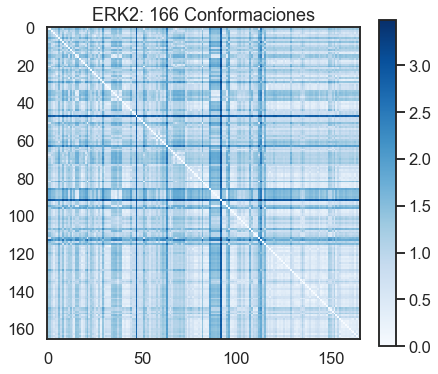

In [52]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(7, 6))
plt.rcParams.update({'font.size': 20})
plt.title("ERK2: 166 Conformaciones")
plt.imshow(pair_rmsd_166_struc, zorder=2, cmap='Blues')
plt.colorbar();

In [53]:
from modules.MDS import cMDS
from modules.plotting_functions import plot_points, plot_anotation_labels

In [54]:
mds_sec_all = cMDS(pair_rmsd_166_struc)

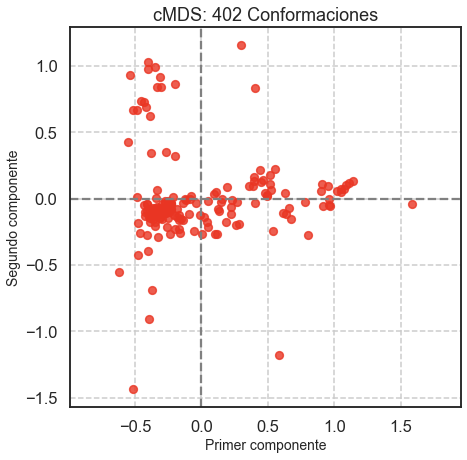

In [57]:
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_sec_all[0], alpha=0.8,
                             title = "cMDS - ERK2:")